## imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import time
import xgboost as xgb
import lightgbm as lgb
# import category_encoders as cat_ed
# import gc, mlcrate, glob

# from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
# from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from IPython.display import display

# from catboost import CatBoostClassifier
# from scipy.cluster import hierarchy as hc
# from collections import Counter

# from sklearn import metrics
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import  roc_auc_score, log_loss
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
# from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
# from sklearn.cluster import KMeans

# from sklearn.metrics import accuracy_score, log_loss
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [3]:
PATH = os.getcwd()
PATH

'D:\\Github\\fastai\\courses\\ml1\\AV_Enigma_ML'

In [4]:
!dir {PATH}

 Volume in drive D is Local Disk
 Volume Serial Number is B408-A348

 Directory of D:\Github\fastai\courses\ml1\AV_Enigma_ML

31-Aug-18  06:00 PM    <DIR>          .
31-Aug-18  06:00 PM    <DIR>          ..
31-Aug-18  05:29 PM    <DIR>          .ipynb_checkpoints
31-Aug-18  06:00 PM           200,571 adi_basics_1.ipynb
31-Aug-18  03:54 PM         3,707,686 Adi_catboost_with rf_feats_310818.csv
31-Aug-18  02:00 PM         3,693,882 Adi_rf_08_58_31-07-2018.csv
31-Aug-18  05:21 PM            13,136 AV_Code_Fest17-master.zip
31-Aug-18  08:14 AM    <SYMLINKD>     fastai [D:\Github\fastai\fastai\]
31-Aug-18  11:20 AM           291,356 initial_eda.ipynb
31-Aug-18  03:54 PM           400,163 ml_bazzokass.ipynb
31-Aug-18  05:29 PM            72,621 Model 5 Factorization machine.ipynb
31-Aug-18  08:02 AM         1,663,873 sample_submission.csv
31-Aug-18  08:04 AM         4,673,330 test.csv
31-Aug-18  02:06 PM        30,850,404 test_new_agg_feats.csv
31-Aug-18  03:45 PM             7,994 time_lef

## importing datasets

In [5]:
df_raw = pd.read_csv(f'{PATH}\\train_new_agg_feats.csv', low_memory=False,dtype='float32')
df_test = pd.read_csv(f'{PATH}\\test_new_agg_feats.csv', low_memory=False, dtype='float32')

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 100): 
        with pd.option_context("display.max_columns", 100): 
            display(df)

def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\sample_submission.csv')
    submit = sample.copy()
    submit['Upvotes'] = probs
    return submit

In [7]:
df_raw.shape,

((330045, 20),)

In [8]:
df_raw.get_ftype_counts()

float32:dense    20
dtype: int64

 pretty cleaned datasets ( Majority numbers, so dont forget to use gplearn (Genetic Programming Module) plus different feats on basis of +,-,*,/

In [9]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Answers                  0.0
Reputation               0.0
Tag                      0.0
Username                 0.0
Views                    0.0
agg_answers              0.0
agg_count                0.0
agg_repo                 0.0
agg_views                0.0
log_trans_Answers        0.0
log_trans_Reputation     0.0
log_trans_Username       0.0
log_trans_Views          0.0
log_trans_agg_answers    0.0
log_trans_agg_count      0.0
log_trans_agg_repo       0.0
log_trans_agg_views      0.0
repo_per_Answers         0.0
repo_per_Views           0.0
target                   0.0
dtype: float64

In [10]:
# df_raw['target'] = np.exp(target) - 1
# df_raw.to_csv(f'{PATH}\\train_new_agg_feats.csv', index=False)
# df_test.to_csv(f'{PATH}\\test_new_agg_feats.csv', index=False)

## Initial Processing

In [11]:
man_train_list = df_raw.Username.unique()
man_test_list = df_test.Username.unique()

man_not_in_test = set(man_train_list) - set(man_test_list)
man_not_in_train = set(man_test_list) - set(man_train_list)

In [12]:
df_raw.drop(index = df_raw.loc[list(man_not_in_test)].index, inplace=True)
target = df_raw.target.values - 1
df_raw.drop('target', axis=1, inplace=True)

## gplearn

In [34]:
function_set = ['add','sub','mul','div','sqrt','log','abs','neg','inv','min','max']
gp = SymbolicTransformer(generations=20,population_size=3000,n_jobs=-1,hall_of_fame=100,n_components=10,verbose=1,\
                        function_set=function_set,parsimony_coefficient=0.005,max_samples=0.9,random_state=123)

In [35]:
gp.fit(df_raw, target)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.46  0.0856001664017       11   0.546226535627   0.395898471233     11.99m
   1     2.47   0.226701150616        5    0.53631944128   0.361121622482      8.97m
   2     1.83   0.372419694023        3    0.54129065652   0.373727015486      7.14m
   3     1.02   0.438522493891        1   0.485452481515   0.275690459055      5.81m
   4     1.03    0.43859950183        1   0.489215109824   0.314471272194      4.88m
   5     1.04   0.438649501971        1   0.483311391918   0.285511885105      3.93m
   6     1.03   0.437855055597        1   0.485281762794   0.330179298756      2.92m
   7     1.02    0.43821215498        1    0.49254926185   0.335685309932      1.96m
   8     1.03   0.437549787264        1    0.48624125194   0.303723289018  

SymbolicTransformer(const_range=(-1.0, 1.0),
          function_set=['add', 'sub', 'div', 'sqrt', 'log', 'inv'],
          generations=10, hall_of_fame=100, init_depth=(2, 6),
          init_method='half and half', max_samples=0.9, metric='pearson',
          n_components=20, n_jobs=-1, p_crossover=0.9,
          p_hoist_mutation=0.01, p_point_mutation=0.01,
          p_point_replace=0.05, p_subtree_mutation=0.01,
          parsimony_coefficient=0.1, population_size=3000,
          random_state=123, stopping_criteria=1.0, tournament_size=20,
          verbose=1, warm_start=False)

In [21]:
gp_feat_eng_train = gp.transform(df_raw)
gp_feat_eng_test = gp.transform(df_test)
ext_train = np.hstack((df_raw, gp_feat_eng_train))
ext_test = np.hstack((df_test, gp_feat_eng_test))

In [28]:
my_xgb = xgb.XGBRegressor(8,0.01,n_jobs=-1,colsample_bytree=0.9,gamma=0.5,silent=False)

In [29]:
my_xgb.fit(ext_train, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.5, learning_rate=0.01,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [30]:
xgb_preds = my_xgb.predict(ext_test)

In [31]:
xgb_preds

array([ 142.54533,   57.61149,   29.44178, ...,   36.5743 ,   12.90634,   18.10994], dtype=float32)

In [32]:
submit = make_submission(xgb_preds)

In [33]:
submit.to_csv(f'{PATH}\\xgb_v1.csv', index=None)

In [38]:
min(xgb_preds), max(xgb_preds)

(7.6774187, 188564.98)

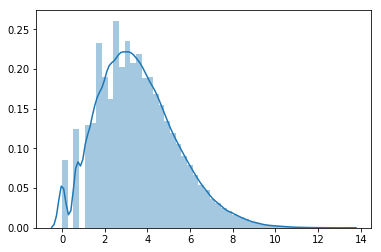

In [42]:
sns.distplot(np.log(target + 1))

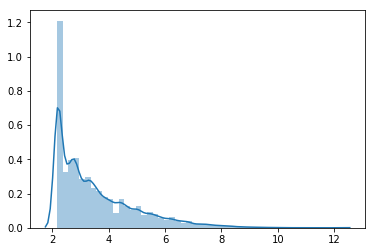

In [43]:
sns.distplot(np.log(xgb_preds + 1))

In [51]:
min(np.percentile(target,[90,91,92,93,94,95,96,97,98,99])), max(np.percentile(target,[90,91,92,93,94,95,96,97,98,99]))

(409.99996948242188, 5137.0815234375168)

In [47]:
np.percentile(xgb_preds,[90,91,92,93,94,95,96,97,98,99])

array([  260.68729,   295.31461,   350.95674,   419.30652,   503.73669,   602.81378,   800.70929,  1054.57312,
        1673.29602,  3313.65591])

In [49]:
np.where(xgb_preds>3313,3313,xgb_preds)

array([ 142.54533,   57.61149,   29.44178, ...,   36.5743 ,   12.90634,   18.10994], dtype=float32)

In [50]:
min(np.where(xgb_preds>3313,3313,xgb_preds)), max(np.where(xgb_preds>3313,3313,xgb_preds))

(7.6774187, 3313.0)

In [52]:
xgb_preds_threshold = np.where(xgb_preds>3313,3313,xgb_preds)

In [53]:
submit = make_submission(xgb_preds_threshold)
submit.to_csv(f'{PATH}\\xgb_v2_thresholding_at_3133.csv', index=None)

In [13]:
# temp1 = df_raw.groupby('Username').count().iloc[:,-1]
# temp2 = df_test.groupby('Username').count().iloc[:,-1]
# df_man = pd.concat([temp1,temp2], axis = 1, join = 'outer')
# df_man.columns = ['train_count','test_count']
# df_man.head(2)

In [14]:
# man_list = df_man['train_count'].sort_values(ascending = False).index
# ixes = df_raw.Username.isin(man_list)
# df10000 = df_raw[ixes][['Username','Tag']]
# tags_dummies = pd.get_dummies(df10000.Tag)
# df10000 = pd.concat([df10000,tags_dummies[['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x']]], axis = 1).drop('Tag', axis = 1)

# # print("The contributors account for {} entries\n".format(len(df10000)))
# # print(df10000.head(10))

In [15]:
# df10000.groupby('Username').count().sort_values(by = 'a', ascending = False).head()

In [21]:
xyz = pd.concat([df_raw.groupby('Username').mean(),df_raw.groupby('Username').count()], axis = 1).iloc[:,:-5]
xyz.columns = ['ID', 'Reputation', 'Answers', 'Views', 'Upvotes', 'count']
############################################################################################# Mean Aggs

unames   = xyz.sort_values(by = 'count', ascending = False).reset_index()['Username'].values.astype('int64')
count    = xyz.sort_values(by = 'count', ascending = False).reset_index()['count'].values.astype('int64')
answers  = xyz.sort_values(by = 'count', ascending = False).reset_index()['Answers'].values.astype('int64')
views    = xyz.sort_values(by = 'count', ascending = False).reset_index()['Views'].values.astype('int64')
repo     = xyz.sort_values(by = 'count', ascending = False).reset_index()['Reputation'].values.astype('int64') 

d = {}
for idx,k in enumerate(unames):
    d[k] = count[idx]
df_raw['agg_count'] = df_raw['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = answers[idx]
df_raw['agg_answers'] = df_raw['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = views[idx]
df_raw['agg_views'] = df_raw['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = repo[idx]
df_raw['agg_repo'] = df_raw['Username'].map(d)

In [22]:
xyz = pd.concat([df_test.groupby('Username').mean(),df_test.groupby('Username').count()], axis = 1).iloc[:,:-4]
xyz.columns = ['ID', 'Reputation', 'Answers', 'Views', 'count']

########################################################################################## Mean Aggregates
unames   = xyz.sort_values(by = 'count', ascending = False).reset_index()['Username'].values.astype('int64')
count    = xyz.sort_values(by = 'count', ascending = False).reset_index()['count'].values.astype('int64')
answers  = xyz.sort_values(by = 'count', ascending = False).reset_index()['Answers'].values.astype('int64')
views    = xyz.sort_values(by = 'count', ascending = False).reset_index()['Views'].values.astype('int64')
repo     = xyz.sort_values(by = 'count', ascending = False).reset_index()['Reputation'].values.astype('int64') 

d = {}
for idx,k in enumerate(unames):
    d[k] = count[idx]
df_test['agg_count'] = df_test['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = answers[idx]
df_test['agg_answers'] = df_test['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = views[idx]
df_test['agg_views'] = df_test['Username'].map(d)

d = {}
for idx,k in enumerate(unames):
    d[k] = repo[idx]
df_test['agg_repo'] = df_test['Username'].map(d)

df_test.head(3)

,ID,Tag,Reputation,Answers,Username,Views,agg_count,agg_answers,agg_views,agg_repo
0,366953,a,5645.0,3.0,50652,33200.0,1,3,33200,5645
1,71864,c,24511.0,6.0,37685,2730.0,9,3,4383,24511
2,141692,i,927.0,1.0,135293,21167.0,1,1,21167,927


In [49]:
add_trans = ['Reputation', 'Answers', 'Username', 'Views', 'agg_count', 'agg_answers', 'agg_views', 'agg_repo']

for col in add_trans:
    df_raw[f'log_trans_{col}'.format(col)] = np.log(df_raw[col] + 1) #avoid log 0's if any
    df_test[f'log_trans_{col}'.format(col)] = np.log(df_test[col] + 1) #avoid log 0's if any
    
df_raw['repo_per_Answers'] = df_raw['Reputation'] / (df_raw['Answers']+1)
df_raw['repo_per_Views']   = df_raw['Reputation'] / df_raw['Views']

df_test['repo_per_Answers'] = df_test['Reputation'] / (df_test['Answers'] +1)
df_test['repo_per_Views']   = df_test['Reputation'] / df_test['Views']

df_raw.shape, df_test.shape

((330045, 19), (141448, 19))

In [24]:
# gby = pd.concat([df10000.groupby('Username').mean(),df10000.groupby('Username').count()], axis = 1).iloc[:,:-9]
# gby.columns = ['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x', 'count']
# gby.sort_values(by = 'count', ascending = False).head(3)[['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x', 'count']]

In [25]:
# gby.sort_values(by = 'count', ascending = False).drop('count', axis = 1).plot(kind = 'bar', stacked = True, figsize = (15,6))
# plt.figure()
# gby.sort_values(by = 'count', ascending = False)['count'].plot(kind = 'bar', figsize = (15,6));

In [26]:
# pd.concat([df_raw['Tag'].value_counts().sort_values(ascending=False),df_test['Tag'].value_counts().sort_values(ascending=False)],sort=False, axis =1,\
#           keys=['Train_Stats', 'Test_Stats'])

In [27]:
# gby.shape

In [28]:
# gby['skill'] = gby['r']*1 + gby['o']*2 + gby['h']*3 + gby['s']*4 + gby['a']*5 + gby['i']*6 + gby['p']*7 + gby['j']*8 \
# + gby['c']*9  

## Baseline RF

In [32]:
##logging Remeber doing np.exp again
df_raw.Upvotes = np.log(df_raw.Upvotes + 2)
target = df_raw.Upvotes.values

In [34]:
drop_cols = ['ID']
df_raw.drop(drop_cols+['Upvotes'],inplace=True,axis=1)
df_test.drop(drop_cols,inplace=True,axis=1)

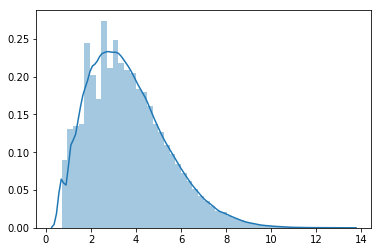

In [35]:
sns.distplot(target)

In [37]:
df_raw.Tag = df_raw.Tag.astype('category')

train_cats(df_raw);
apply_cats(df_test, df_raw);

df_raw.Tag = df_raw.Tag.cat.codes
df_test.Tag = df_test.Tag.cat.codes

In [40]:
df_raw.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

In [51]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw, target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [66]:
# print('Before -->>', df_raw.shape)
# df_raw.drop(index = df_raw.loc[list(man_not_in_test)].index, inplace=True)
# print('After -->>', df_raw.shape)

In [55]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw, target)
m.score(df_raw,target)

0.97099962844474397

todo define r^2

Wow, an r^2 of 0.9699 - that's great, right? Well, perhaps not...

Possibly the most important idea in machine learning is that of having separate training & validation data sets

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_raw, target, test_size=0.2, random_state=42)

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 30000
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_raw, n_trn)
y_train, y_valid = split_vals(target, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((300045, 19), (300045,), (30000, 19))

In [59]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = ['RMSLE X_train', rmse(m.predict(X_train), y_train), '\n RMSLE X_valid', rmse(m.predict(X_valid), y_valid),
                '\n R**2 Train',m.score(X_train, y_train), '\n R**2 Valid', m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(['\n OOB_Score', m.oob_score_])
    print(res)

In [60]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.2984545307558587, '\n RMSLE X_valid', 0.7037925261625434, '\n R**2 Train', 0.97087666383300619, '\n R**2 Valid', 0.84038977376410606]


It's Pathetic as We are Clearly Overfitting...
Have a look at the RM(L)SE Scores and the Accuracy...
They aree way too off...

In [102]:
m.fit(df,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
preds = np.exp(m.predict(df_test)).astype('int32') - 1;
preds

array([178,  71,  31, ...,  54,  11,  36])

In [62]:
submit = make_submission(preds)
submit.to_csv(f'{PATH}\\Adi_rf_08_58_31-07-2018.csv', index=False)
submit.head(2)

,ID,Upvotes
0,7,178
1,9,71


## Single Tree

In [65]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.9655662548817948, '\n RMSLE X_valid', 0.9709339462623273, '\n R**2 Train', 0.69517616006398919, '\n R**2 Valid', 0.69622587209592302]


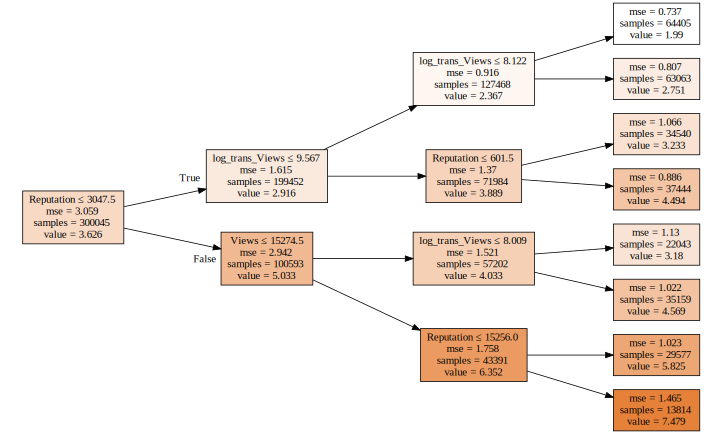

In [66]:
draw_tree(m.estimators_[0], df_raw, precision=3)

In [67]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 3.3744783804442027e-06, '\n RMSLE X_valid', 0.9437620200303372, '\n R**2 Train', 0.99999999999627698, '\n R**2 Valid', 0.71299041286213283]


## Bagging

In [112]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.3342668840281541, '\n RMSLE X_valid', 0.759811492525464, '\n R**2 Train', 0.96739614972223364, '\n R**2 Valid', 0.83081486560338891]


In [113]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 4.07754,  2.63906,  4.64439,  2.19722,  3.09104,  4.04305,  3.98898,  1.79176,  3.3322 ,  1.60944]),
 3.1414689909593068,
 0.0)

In [114]:
preds.shape

(10, 50000)

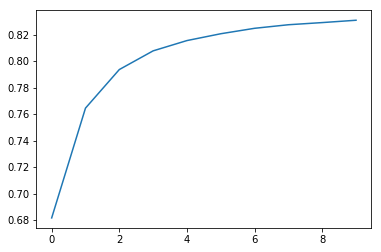

In [115]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much

In [116]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.306842367237855, '\n RMSLE X_valid', 0.7434485978658482, '\n R**2 Train', 0.97252657317513436, '\n R**2 Valid', 0.83802336300925362]


In [117]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.2929252443065499, '\n RMSLE X_valid', 0.7329716058914498, '\n R**2 Train', 0.97496222191986837, '\n R**2 Valid', 0.84255648154121054]


In [119]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.2852309569425325, '\n RMSLE X_valid', 0.7285910317128514, '\n R**2 Train', 0.97626028493061956, '\n R**2 Valid', 0.84443276718525839]


## OOF's

In [122]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.2924712186331809, '\n RMSLE X_valid', 0.7334538469518493, '\n R**2 Train', 0.97503977743546122, '\n R**2 Valid', 0.84234924102755637, ['\n OOB_Score', 0.82001540793601491]]


In [125]:
X_valid.shape, X_train.shape

((50000, 6), (30000, 6))

In [128]:
df_trn, y_trn, nas = proc_df(df_raw, 'Upvotes', max_n_cat=20)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [129]:
set_rf_samples(50000)

In [130]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 2.93 s
['RMSLE X_train', 0.6585916529938831, '\n RMSLE X_valid', 0.7692169494974488, '\n R**2 Train', 0.87221996680169545, '\n R**2 Valid', 0.82660036666041081, ['\n OOB_Score', 0.82023265348280416]]


In [131]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.6243659866102018, '\n RMSLE X_valid', 0.7419510241683946, '\n R**2 Train', 0.88515581117942965, '\n R**2 Valid', 0.83867526453450369, ['\n OOB_Score', 0.83647805582264023]]


In [132]:
reset_rf_samples()

In [133]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.2886437762748644, '\n RMSLE X_valid', 0.7537761672788738, '\n R**2 Train', 0.97545545714548143, '\n R**2 Valid', 0.83349192953022089, ['\n OOB_Score', 0.82502288253799794]]


In [134]:
X_train.shape

(280045, 6)

In [138]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.43310311618640557, '\n RMSLE X_valid', 0.7464085608473503, '\n R**2 Train', 0.94473970877760383, '\n R**2 Valid', 0.83673100929294175, ['\n OOB_Score', 0.83060836747957101]]


RMSLE FOR VALID IS TOO HIGH, we need to change the randomness i guess

In [69]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
1,Reputation,0.427378
4,Views,0.228690
12,log_trans_Views,0.184093
9,log_trans_Reputation,0.046276
18,repo_per_Views,0.016092
17,repo_per_Answers,0.014620
11,log_trans_Username,0.011729
3,Username,0.011557
0,Tag,0.011386
15,log_trans_agg_views,0.009237


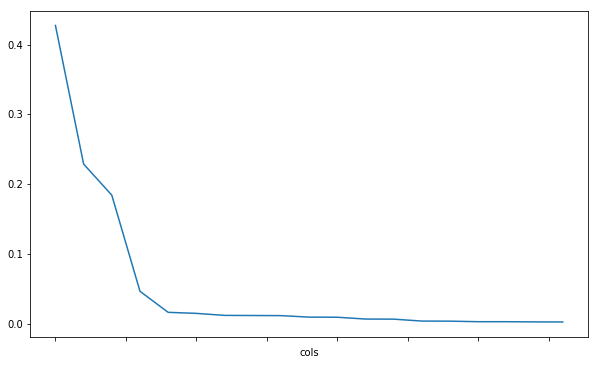

In [70]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [71]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

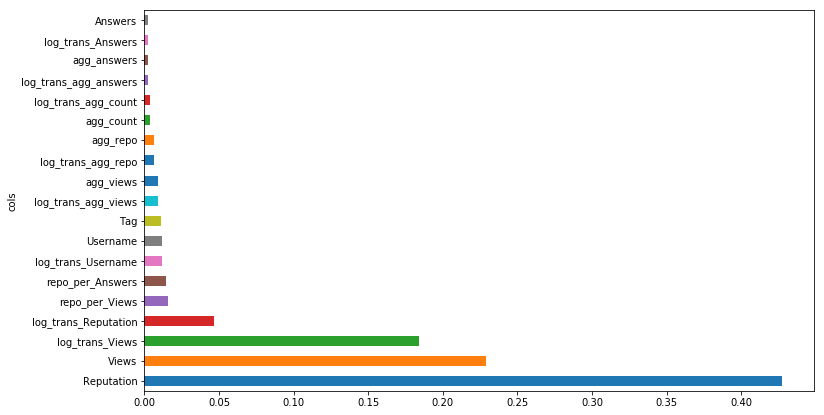

In [73]:
plot_fi(fi[:]);

In [74]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

13

In [76]:
df_keep = df_raw[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [77]:
from scipy.cluster import hierarchy as hc

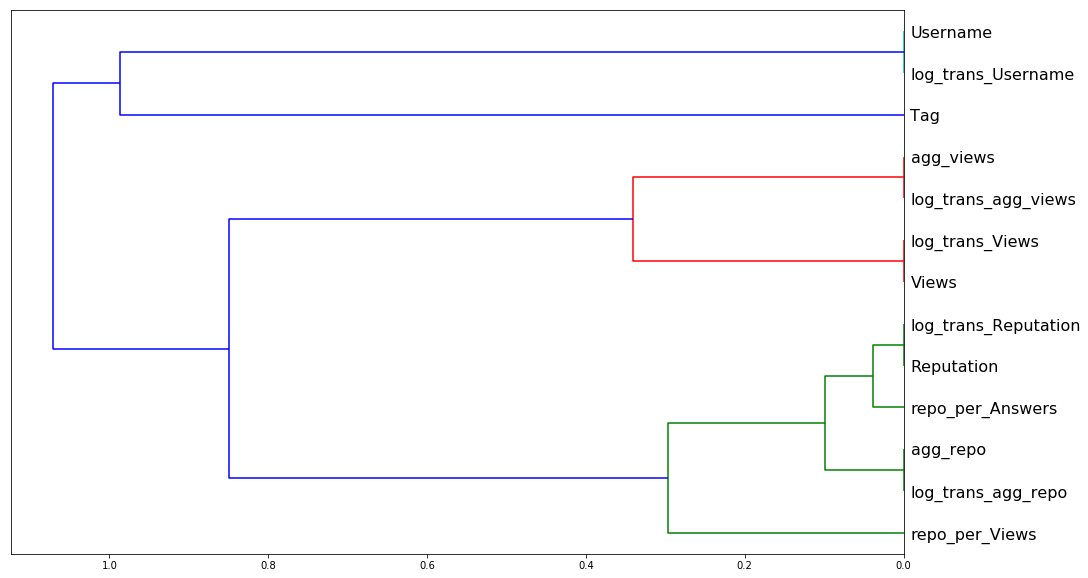

In [78]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)

In [79]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['RMSLE X_train', 0.4017516915982445, '\n RMSLE X_valid', 0.6685437905376493, '\n R**2 Train', 0.94722840764220806, '\n R**2 Valid', 0.8559772395002534, ['\n OOB_Score', 0.85034985887008385]]


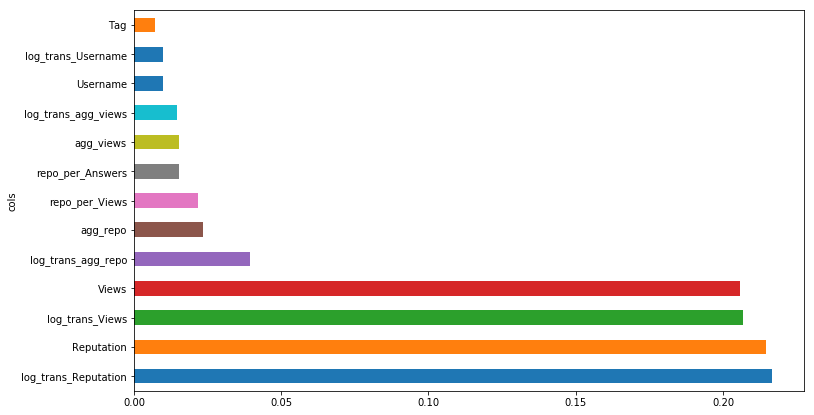

In [80]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [81]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [82]:
get_oob(df_keep)

0.85198405820911227

In [83]:
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [85]:
preds = np.exp(m.predict(df_test[to_keep])) - 1;
preds

array([ 223.08395,   72.16947,   28.37327, ...,   50.06611,   14.87964,   26.97834])

In [86]:
submit = make_submission(preds)
submit.to_csv(f'{PATH}\\Adi_rf_08_58_31-07-2018.csv', index=False)
submit.head(2)

,ID,Upvotes
0,7,223.083948
1,9,72.169465
